In [1]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns
from pymutspec.annotation.spectra import CodonAnnotation
from pymutspec.constants import possible_sbs192
from pymutspec.draw import plot_mutspec192
import pymutspec

from Bio import SeqIO
from Bio.Data import CodonTable
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")

In [6]:
paths12 = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

paths_history = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/.nextflow/history')

gene_species = set([x.split('/')[5] for x in paths12])

## Execution time

In [7]:
h_pattern = re.compile("(\d{0,2})h")
m_pattern = re.compile("(\d{0,2})m")
s_pattern = re.compile("(\d{0,2})s")

def time_fmt(s):
    hours = mins = secs = 0
    h = h_pattern.search(s)
    if h:
        hours = int(h.group()[:-1])
    m = m_pattern.search(s)
    if m:
        mins = int(m.group()[:-1])
    sec = s_pattern.search(s)
    if sec:
        secs = int(sec.group()[:-1])
    return hours * 60 + mins + secs / 60

In [8]:
time_fmt('2h 1m 21s')

121.35

In [24]:
data = []
nerr = 0
for p in paths_history:
    p_elements = p.split('/')
    if p_elements[8] in gene_species:
        gene = p_elements[7]
        gs = p_elements[8]
        hist = pd.read_csv(p, sep='\t', header=None).iloc[0]
        ok = hist[3]
        if ok != 'OK':
            nerr += 1
        time_raw = hist[1]
        minuts = time_fmt(time_raw)
        nleaves = 0
        with open('/'.join(p_elements[:9]) + '/logs/branches.txt') as fin:
            for line in fin:
                nleaves += 1
        data.append([nleaves, minuts, gene, gs])

df = pd.DataFrame(data, columns=['nleaves', 'minuts', 'gene', 'gs'])

In [25]:
df.sort_values('minuts', ascending=False)

,nleaves,minuts,gene,gs


In [17]:
df.groupby('gene')[['nleaves', 'minuts']].describe()

Series([], dtype: float64)

In [ ]:
df[df.nleaves.between(80, 120)].groupby('gene').minuts.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,13.0,3.938462,1.029257,2.816667,3.250000,3.683333,3.916667,5.983333
A8,1.0,3.716667,NaN,3.716667,3.716667,3.716667,3.716667,3.716667
CO1,14.0,6.153571,1.469900,4.083333,5.162500,5.875000,6.937500,8.600000
CO2,2.0,3.866667,0.235702,3.700000,3.783333,3.866667,3.950000,4.033333
CO3,8.0,3.870833,0.536135,3.000000,3.508333,3.983333,4.245833,4.550000
Cytb,150.0,4.639778,0.924764,3.216667,3.987500,4.450000,5.166667,7.016667
ND1,16.0,4.535417,0.972147,3.300000,3.745833,4.275000,4.933333,6.766667
ND2,80.0,5.270833,1.384746,3.616667,4.408333,4.925000,5.812500,12.733333
ND3,2.0,3.525000,0.671751,3.050000,3.287500,3.525000,3.762500,4.000000


In [25]:
ax = sns.jointplot(df, x='nleaves', y='minuts', hue='gene')
plt.vlines([df.nleaves.mean()], 0, 100);
plt.hlines([df.minuts.mean()], 0, 550);


NameError: name 'df' is not defined

## Aggregate

In [4]:
paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('../data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('../data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

In [4]:
total_data = []
for lbl, paths in zip(['12', '192', '12_internal', '192_internal'],
                      [paths12, paths192, paths12_internal, paths192_internal]):
    data = []
    for p in tqdm.tqdm(paths, 'Species-Gene'):
        gene, species = p.split('/')[5].split('__')
        spectrum = pd.read_csv(p, sep='\t')
        spectrum = spectrum.assign(Species=species, Gene=gene)
        data.append(spectrum)
    df = pd.concat(data)
    total_data.append(df.copy())
    df.to_csv(f'../data/chordata2/raw_spectum{lbl}.csv')

Species-Gene: 100%|██████████| 5925/5925 [00:11<00:00, 508.59it/s]


## Process

In [3]:
total_data = [
    pd.read_csv('../data/chordata2/raw_spectum12.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum12_internal.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192_internal.csv', index_col=0),
]

In [4]:
df_info = pd.read_csv('../data/chordata2/info.csv')
df_info['species'] = df_info['species'].str.replace(' ', '_')
df_info

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_pyrrhogaster


### Calculate class abundance

In [9]:
cab = total_data[0].merge(df_info, right_on=['species', 'gene'], left_on=['Species', 'Gene'])
cab['cls'] = cab.taxa.apply(lambda x: ' '.join(x.split(';')[1].split('_')[:-1]))
abund = cab.drop_duplicates(['species', 'gene']).groupby(['cls', 'gene']).Species.count()\
    .unstack().fillna(0).astype(int).sort_values('Cytb', ascending=False)

In [10]:
abund = abund.append(pd.Series({'Cytb': 33962,
         'CO1': 33506,
         'ND2': 23602,
         'ND4': 14985,
         'ND3': 12754,
         'ND1': 12684,
         'A6': 12543,
         'A8': 12033,
         'CO2': 10931,
         'ND5': 10789,
         'CO3': 10428,
         'ND4L': 10350,
         'ND6': 10300}, name='Total'))

abund.to_csv('../data/supplementary_files/Supplementary_Table_3.csv')

/tmp/ipykernel_1190126/1788666815.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  abund = abund.append(pd.Series({'Cytb': 33962,


In [11]:
abund

,A6,A8,CO1,CO2,CO3,Cytb,ND1,ND2,ND3,ND4,ND4L,ND5,ND6
cls,,,,,,,,,,,,,
Mammalia,121,70,309,145,142,1123,153,210,97,174,81,155,118
Actinopteri,167,56,334,31,34,1026,76,235,25,68,21,57,40
Lepidosauria,51,21,110,7,8,435,61,425,5,337,5,12,8
Aves,122,23,79,40,44,314,44,718,79,60,14,57,61
Amphibia,14,5,135,8,13,242,63,181,22,52,5,20,12
class Testudines,0,0,3,0,0,40,1,1,1,16,0,2,2
class Crocodylia,1,1,3,1,1,10,1,1,1,1,1,1,1
Hyperoartia,2,1,1,0,0,9,0,1,1,0,0,0,0
Chondrichthyes,5,3,15,1,1,8,1,46,0,5,0,4,1


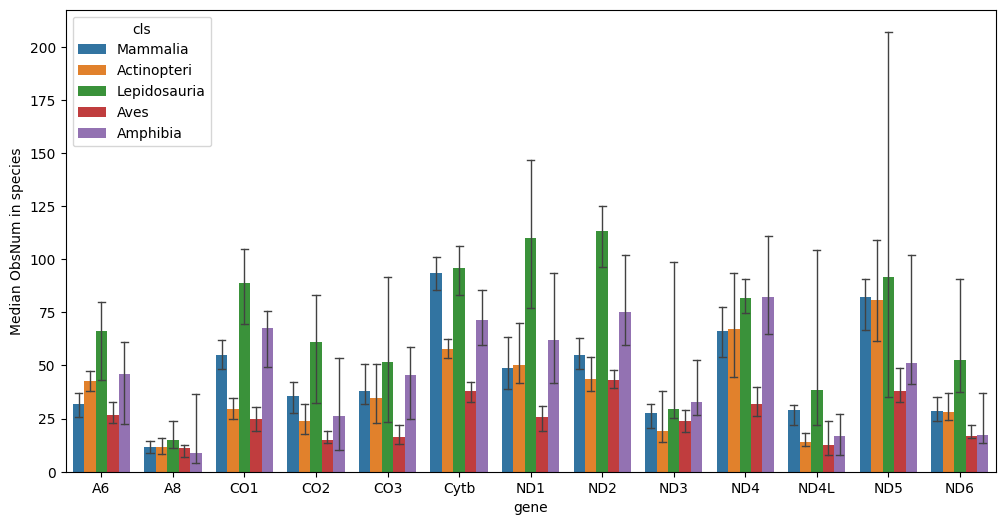

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cab.groupby(['cls', 'gene', 'species']).ObsNum.sum().reset_index(), 
    x='gene', y='ObsNum', hue='cls', 
    hue_order=['Mammalia', 'Actinopteri', 'Lepidosauria', 'Aves', 'Amphibia'],
    capsize=0.1, estimator='median', errwidth=1,
).set_ylabel('Median ObsNum in species');

## Find errors

## Get final tables; find min number of mutations threshold 

In [5]:
total_data[0]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
0,A>G,11.97280,30.91470,0.370075,Eleotris_fusca,ND1
1,C>T,4.98631,46.08120,0.103398,Eleotris_fusca,ND1
2,G>A,6.98846,21.08200,0.316758,Eleotris_fusca,ND1
3,T>C,8.98184,40.91500,0.209769,Eleotris_fusca,ND1
4,T>A,0.00000,16.91510,0.000000,Eleotris_fusca,ND1
...,...,...,...,...,...,...
7,T>C,2.99998,40.79990,0.026493,Branchiostoma_belcheri,ND4L
8,T>G,3.99994,10.90000,0.132223,Branchiostoma_belcheri,ND4L
9,G>T,0.00000,4.69996,0.000000,Branchiostoma_belcheri,ND4L
10,A>C,0.00000,12.90000,0.000000,Branchiostoma_belcheri,ND4L


<AxesSubplot:>

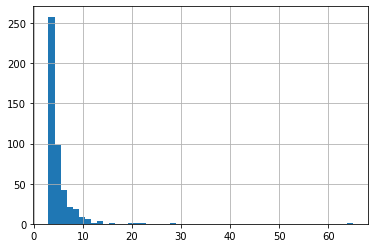

In [42]:
a = (total_data[0].ObsNum / total_data[0].ExpNum)
a[a > 3].hist(bins=50)

In [62]:
tr_space = np.linspace(0, 5, 100)
dlen = [total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))].shape[0] for tr in tr_space]

In [86]:
tr = 0.99
total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))] #& (~(total_data[0].ObsNum / total_data[0].ExpNum).fillna(0).between(0.8, 1.2))]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
4,G>C,0.984329,0.532810,0.293537,Podarcis_lilfordi,ND2
6,G>T,0.981711,0.943558,0.099573,Pedioplanis_burchelli,ND2
6,G>T,0.808355,0.537496,0.197909,Didemnum_granulatum,CO1
4,G>A,0.899284,0.872553,0.368168,Crotaphytus_nebrius,Cytb
7,G>C,0.567060,0.320491,0.394275,Reithrodontomys_chrysopsis,Cytb
5,G>A,0.973297,0.571058,0.592833,Dipodomys_agilis,Cytb
6,G>T,0.800593,0.911391,0.123866,Misgurnus_anguillicaudatus,A8
4,G>T,0.984943,0.317911,0.396533,Phrynosoma_orbiculare,A8
2,G>A,0.966622,0.305126,0.656641,Dicrostonyx_torquatus,A8
1,C>A,0.317641,0.022745,0.694539,Pituophis_deppei,A8


In [91]:
total_data[0][(total_data[0].ExpNum.between(0.99, 1, 'right')) | (total_data[0].ObsNum.between(0.99, 1, 'right'))] 

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
3,C>G,1.00000,23.59860,0.012763,Anaxyrus_fowleri,ND1
1,A>T,1.00000,80.26720,0.011597,Anaxyrus_woodhousii,ND1
5,G>C,1.00000,6.67245,0.139505,Anaxyrus_woodhousii,ND1
2,A>T,1.00000,22.64750,0.021682,Corvus_corax,ND1
8,T>G,0.99997,21.06580,0.010808,Lasiopodomys_gregalis,ND1
...,...,...,...,...,...,...
1,C>A,1.00000,13.99980,0.103928,Macrhybopsis_aestivalis,ND4L
5,T>G,1.00000,8.98997,0.161843,Macrhybopsis_aestivalis,ND4L
2,C>A,0.99998,2.50000,0.144122,Branchiostoma_belcheri,ND4L
5,G>C,0.99995,4.69996,0.076659,Branchiostoma_belcheri,ND4L


In [93]:
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[2].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.25, .5, .75])

0.25    0.940835
0.50    0.981491
0.75    0.993853
dtype: float64

In [95]:
tr = 0.99
get_cossim(
    total_data[0][(total_data[0].ExpNum > tr) & (total_data[0].ObsNum > tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[2][(total_data[2].ExpNum > tr) & (total_data[2].ObsNum > tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.25, .5, .75])

0.25    0.937508
0.50    0.981007
0.75    0.993736
dtype: float64

In [96]:
tr = 0.99
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[0][(total_data[0].ExpNum >= tr) & (total_data[0].ObsNum >= tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.05, .5])

0.05    0.988551
0.50    1.000000
dtype: float64

## Compare with old dataset 

In [97]:
spectra_old = pd.read_csv('../../192/data/MutSpecVertebratescytb.csv')
spectra_old

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii
...,...,...,...,...,...,...,...,...,...,...
187003,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves
187004,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves
187005,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves
187006,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves


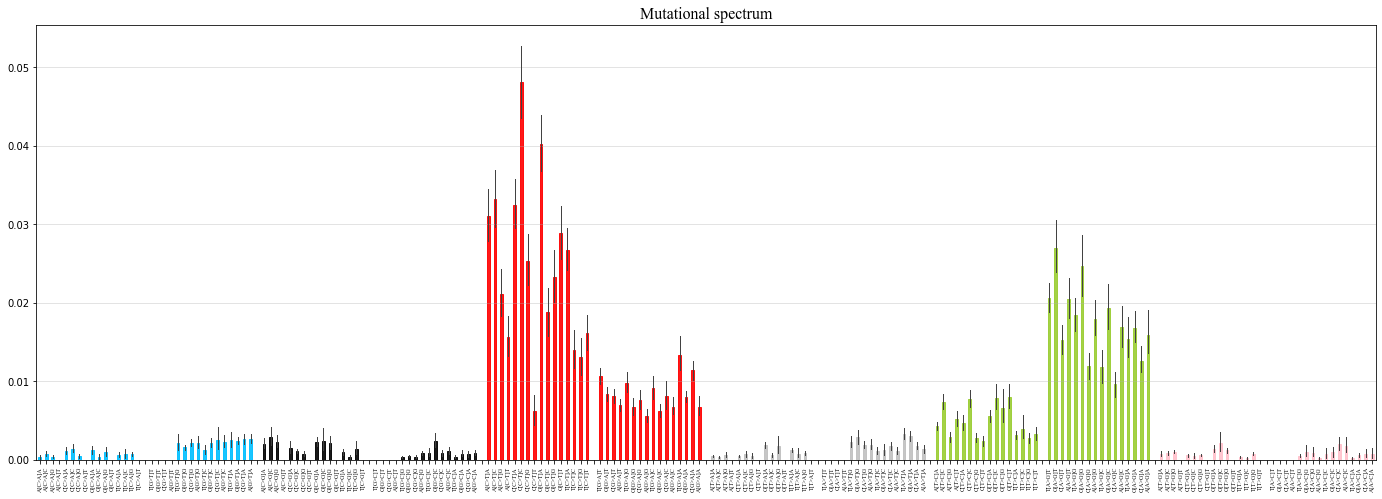

In [99]:
plot_mutspec192(spectra_old)

In [124]:
df = total_data[1][(total_data[1].Gene == 'Cytb') & (total_data[1].ExpNum > 0.99) & (total_data[1].ObsNum > 0.99)].reset_index(drop=True)

df['RawMutSpec'] = (df.ObsNum / df.ExpNum).fillna(0.)
sp2rawspecsum = df.groupby('Species').RawMutSpec.sum().to_dict()
df['RawMutSpecSum'] = df.Species.map(sp2rawspecsum)
df['MutSpec'] = df['RawMutSpec'] / df['RawMutSpecSum']

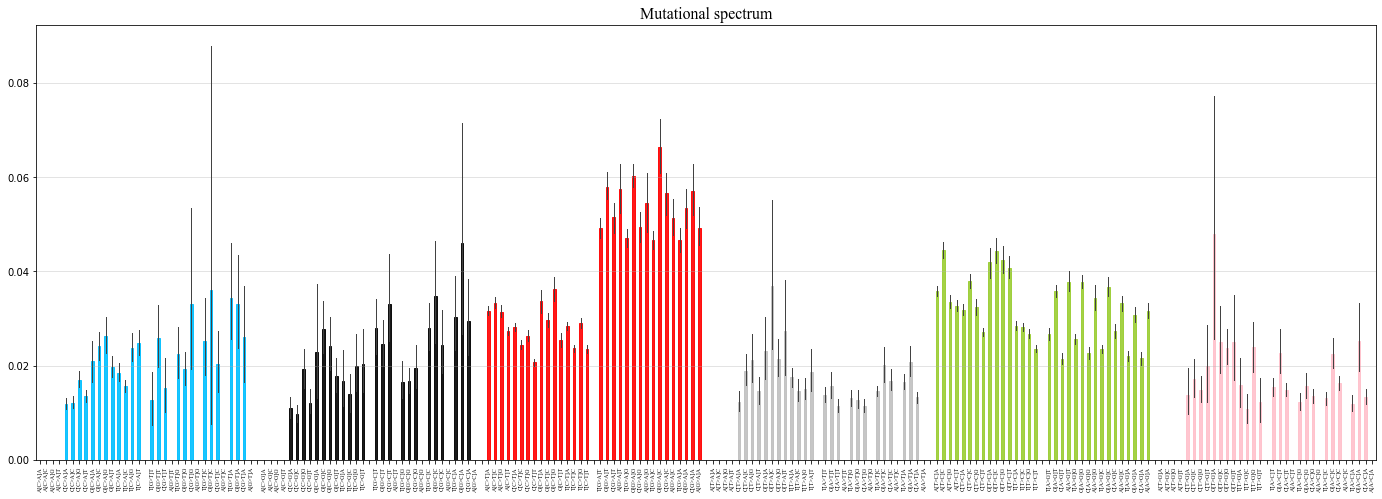

In [125]:
plot_mutspec192(df)

580


<AxesSubplot:>

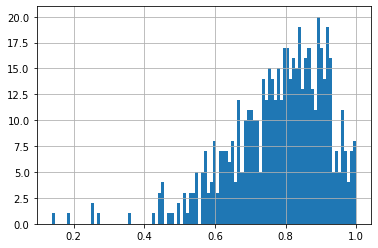

In [163]:
thr = 1.5
spectra_new = total_data[1][(total_data[1].Gene == 'Cytb') & (total_data[1].ObsNum > thr) & (total_data[1].ExpNum > thr)].reset_index(drop=True)
spectra_new['Mut'] = spectra_new['Mut'].apply(pymutspec.annotation.rev_comp)

both = spectra_new.merge(spectra_old, on=['Species', 'Mut'], suffixes=['_new', '_old'])
print(both.groupby('Species').Mut.count().shape[0])

get_cossim(
    both.pivot(['Species'], 'Mut', 'MutSpec_new'), 
    both.pivot(['Species'], 'Mut', 'MutSpec_old'), 
).hist(bins=100)

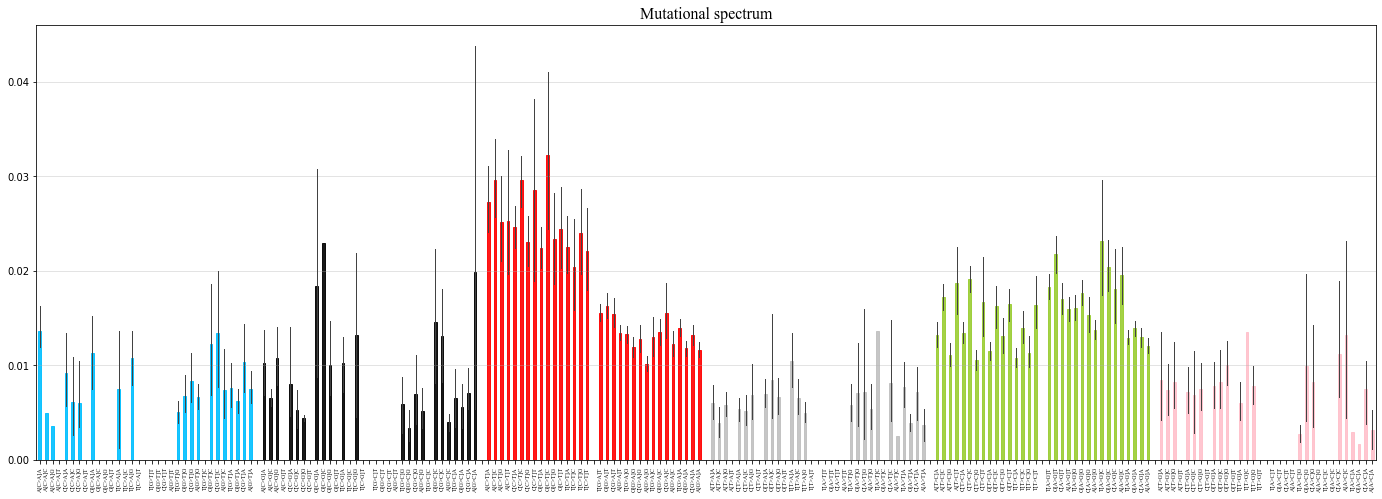

In [166]:
plot_mutspec192(both, 'MutSpec_new')

In [137]:
both.pivot(['Species'], 'Mut', 'MutSpec_old')

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[A>T]A,A[A>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Species,,,,,,,,,,,,,,,,,,,,,
Abbottina_rivularis,0.000000,0.0,0.0,0.0,0.002474,0.000000,0.000000,0.000000,0.0,0.014842,...,0.000000,0.0,0.005937,0.000000,0.004947,0.004947,0.002474,0.0,0.000000,0.0
Abramis_brama,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.014925,0.026533,0.0,0.000000,...,0.000000,0.0,0.027554,0.000000,0.010855,0.000000,0.000000,0.0,0.000000,0.0
Acanthopagrus_latus,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Acheilognathus_macropterus,0.002856,0.0,0.0,0.0,0.004422,0.005712,0.008886,0.016502,0.0,0.000000,...,0.000000,0.0,0.005193,0.003264,0.004394,0.002285,0.000000,0.0,0.001758,0.0
Acheilognathus_rhombeus,0.000000,0.0,0.0,0.0,0.008932,0.100043,0.004547,0.012505,0.0,0.000000,...,0.000000,0.0,0.004547,0.008337,0.000000,0.005002,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xiphias_gladius,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.060731,0.025304,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.043379,0.000000,0.0,0.000000,0.0
Xiphophorus_hellerii,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.063918,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Zacco_platypus,0.000000,0.0,0.0,0.0,0.007255,0.016325,0.003957,0.013301,0.0,0.000000,...,0.002177,0.0,0.006219,0.003628,0.008706,0.006802,0.002177,0.0,0.000000,0.0


In [126]:
df.groupby('Species').MutSpec.sum().value_counts()

1.0    2422
1.0     383
1.0      11
Name: MutSpec, dtype: int64

### DI Calculate Expected Mutspec with conservative sites for CytB

In [2]:
paths192 = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/Cytb/*/seqs_unique.fasta')

In [3]:
coda = CodonAnnotation(gencode=2)

In [4]:
exp_final_df = pd.DataFrame()
list_of_species = list()

for path_fasta in paths192:
    ### gene = 'Cytb'

    p_elements = path_fasta.split('/')
    
    species_name = p_elements[8].split('__')[1]
    list_of_species.append(species_name)
    
    exp_192_for_one_species = defaultdict(int)
    n_species = 0


    for unique_rec in SeqIO.parse(path_fasta, 'fasta'):
        
        if unique_rec.id is not 'OUTGRP':
            
            n_species += 1
            exp12_for_rec, exp192_for_rec = coda.collect_exp_mut_freqs(unique_rec.seq, None, ['syn'])

            for sbs in exp192_for_rec['syn']:
                exp_192_for_one_species[sbs] += exp192_for_rec['syn'][sbs]
    
    ### Norm on number of species in fasta file
    for sbs in exp_192_for_one_species:
        exp_192_for_one_species[sbs] = exp_192_for_one_species[sbs] / n_species
    
    exp_final_df = pd.concat([exp_final_df, pd.DataFrame(exp_192_for_one_species, index = [species_name])], ignore_index=False)
    

In [5]:
exp_final_df.head()

,C[A>C]C,C[A>T]C,C[A>G]C,A[A>G]A,T[C>T]A,C[C>A]G,C[C>T]G,C[C>G]G,G[C>T]C,G[C>G]C,...,C[T>G]W,A[G>A]K,C[A>C]D,C[A>G]D,C[A>T]D,T[A>C]D,T[A>T]D,T[A>G]D,G[T>G]S,G[T>A]S
Aulacorhynchus_haematopygus,4.636364,4.636364,4.636364,6.272727,17.727273,3.727273,3.727273,3.727273,5.090909,3.818182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tarsius_dentatus,10.045455,10.045455,10.045455,8.818182,10.909091,3.863636,3.863636,3.863636,4.590909,2.590909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xanthonycticebus_pygmaeus,8.722222,8.722222,8.722222,8.388889,15.000000,3.055556,3.055556,3.055556,3.888889,0.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pedioplanis_inornata,4.488372,4.488372,4.488372,5.906977,5.604651,7.604651,7.604651,7.604651,5.418605,3.418605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oligoryzomys_fulvescens,7.846154,7.846154,7.846154,9.230769,10.769231,2.538462,2.538462,2.538462,5.384615,3.615385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
exp_filtered = exp_final_df.loc[:, exp_final_df.columns.isin(possible_sbs192)]
for sbs in possible_sbs192:
    if sbs not in exp_filtered.columns:
        exp_filtered[sbs] = 0

exp_filtered.head()

,C[A>C]C,C[A>T]C,C[A>G]C,A[A>G]A,T[C>T]A,C[C>A]G,C[C>T]G,C[C>G]G,G[C>T]C,G[C>G]C,...,A[G>T]G,A[G>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T
Aulacorhynchus_haematopygus,4.636364,4.636364,4.636364,6.272727,17.727273,3.727273,3.727273,3.727273,5.090909,3.818182,...,0,0,0,0,0,0,0,0,0,0
Tarsius_dentatus,10.045455,10.045455,10.045455,8.818182,10.909091,3.863636,3.863636,3.863636,4.590909,2.590909,...,0,0,0,0,0,0,0,0,0,0
Xanthonycticebus_pygmaeus,8.722222,8.722222,8.722222,8.388889,15.000000,3.055556,3.055556,3.055556,3.888889,0.055556,...,0,0,0,0,0,0,0,0,0,0
Pedioplanis_inornata,4.488372,4.488372,4.488372,5.906977,5.604651,7.604651,7.604651,7.604651,5.418605,3.418605,...,0,0,0,0,0,0,0,0,0,0
Oligoryzomys_fulvescens,7.846154,7.846154,7.846154,9.230769,10.769231,2.538462,2.538462,2.538462,5.384615,3.615385,...,0,0,0,0,0,0,0,0,0,0


In [7]:
exp_filtered = exp_filtered.reset_index()
exp_filtered = exp_filtered.rename(columns={'index':'Species'})

In [8]:
exp_true_form = exp_filtered.melt(id_vars=['Species'], value_vars=possible_sbs192)
exp_true_form = exp_true_form.rename(columns={'variable': 'Mut', 'value' : 'ExpectedNum'})
exp_true_form.head()

,Species,Mut,ExpectedNum
0,Aulacorhynchus_haematopygus,A[A>C]A,0.0
1,Tarsius_dentatus,A[A>C]A,0.0
2,Xanthonycticebus_pygmaeus,A[A>C]A,0.0
3,Pedioplanis_inornata,A[A>C]A,0.0
4,Oligoryzomys_fulvescens,A[A>C]A,0.0


In [9]:
path_to_observed_192 = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/Cytb/*/tables/ms192syn.tsv')

In [10]:
full_obs = pd.DataFrame()
for obs_spec in path_to_observed_192:
    
    mutspec_sps = pd.read_csv(obs_spec, sep='\t')
    mutspec_sps['Species'] = obs_spec.split('/')[8].split('__')[1]
    full_obs = pd.concat([full_obs, mutspec_sps], ignore_index=True)


In [11]:
full_obs.head()

,Mut,ObsNum,ExpNum,MutSpec,Species
0,A[A>G]C,0.95618,2.995130,0.019676,Aulacorhynchus_haematopygus
1,A[C>T]A,0.99706,4.777330,0.012863,Aulacorhynchus_haematopygus
2,A[C>T]G,0.99898,3.111040,0.019791,Aulacorhynchus_haematopygus
3,A[T>C]A,0.99983,0.222221,0.277305,Aulacorhynchus_haematopygus
4,A[T>C]C,0.99879,0.555528,0.110812,Aulacorhynchus_haematopygus


In [12]:
# Merge it 
final_mutspec = full_obs.merge(exp_true_form, how='inner', on=['Species', 'Mut'])
final_mutspec.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,ExpectedNum
0,A[A>G]C,0.95618,2.995130,0.019676,Aulacorhynchus_haematopygus,6.363636
1,A[C>T]A,0.99706,4.777330,0.012863,Aulacorhynchus_haematopygus,10.818182
2,A[C>T]G,0.99898,3.111040,0.019791,Aulacorhynchus_haematopygus,5.636364
3,A[T>C]A,0.99983,0.222221,0.277305,Aulacorhynchus_haematopygus,1.454545
4,A[T>C]C,0.99879,0.555528,0.110812,Aulacorhynchus_haematopygus,0.454545


In [13]:
# Filter those who has more then 0.99 in both Exp and Obs num put 0 instead
final_mutspec['ExpectedNum'] = np.where(final_mutspec.ExpectedNum < 0.99, 0, final_mutspec['ExpectedNum'])
final_mutspec['ObsNum'] = np.where(final_mutspec.ObsNum < 0.99, 0, final_mutspec['ObsNum'])

In [14]:
# Calcualte MutSpec
final_mutspec["RawMutSpec"] = (final_mutspec["ObsNum"] / final_mutspec["ExpectedNum"]).fillna(0)
final_mutspec["RawMutSpec"] = final_mutspec["RawMutSpec"].replace(np.inf, 0)
rawsum_df = final_mutspec.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
final_mutspec = pd.merge(final_mutspec, rawsum_df, on="Species")
final_mutspec["MutSpec"] = final_mutspec["RawMutSpec"] / final_mutspec["RawMutSpecSum"]
final_mutspec.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,ExpectedNum,RawMutSpec,RawMutSpecSum
0,A[A>G]C,0.00000,2.995130,0.000000,Aulacorhynchus_haematopygus,6.363636,0.000000,5.866775
1,A[C>T]A,0.99706,4.777330,0.015710,Aulacorhynchus_haematopygus,10.818182,0.092165,5.866775
2,A[C>T]G,0.99898,3.111040,0.030211,Aulacorhynchus_haematopygus,5.636364,0.177238,5.866775
3,A[T>C]A,0.99983,0.222221,0.117165,Aulacorhynchus_haematopygus,1.454545,0.687383,5.866775
4,A[T>C]C,0.99879,0.555528,0.000000,Aulacorhynchus_haematopygus,0.000000,0.000000,5.866775


In [15]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [16]:
# A bit annotate
final_mutspec['Mut'] = final_mutspec.Mut.apply(getrevers) # translation on heavy chain
final_mutspec["MutBase"] = final_mutspec.Mut.str.slice(2, 5)
final_mutspec["Context"] = final_mutspec.Mut.str.get(0) + final_mutspec.Mut.str.get(2) + final_mutspec.Mut.str.get(-1)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


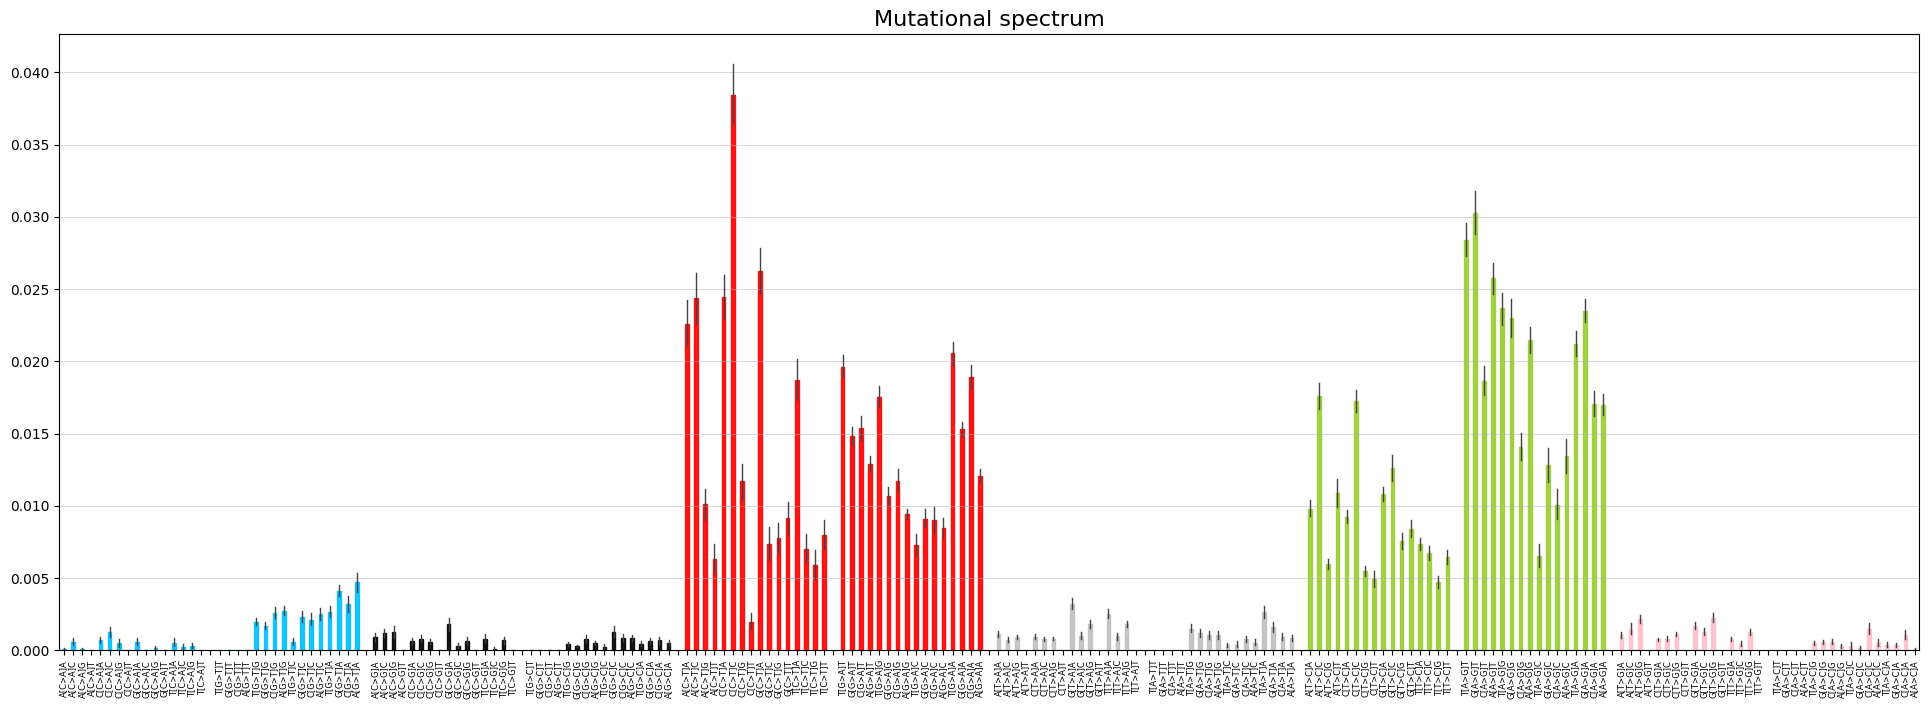

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [17]:
plot_mutspec192(final_mutspec)

In [18]:
spectra_old = pd.read_csv('/home/kpotoh/192/data/MutSpecVertebratescytb.csv')
spectra_old.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


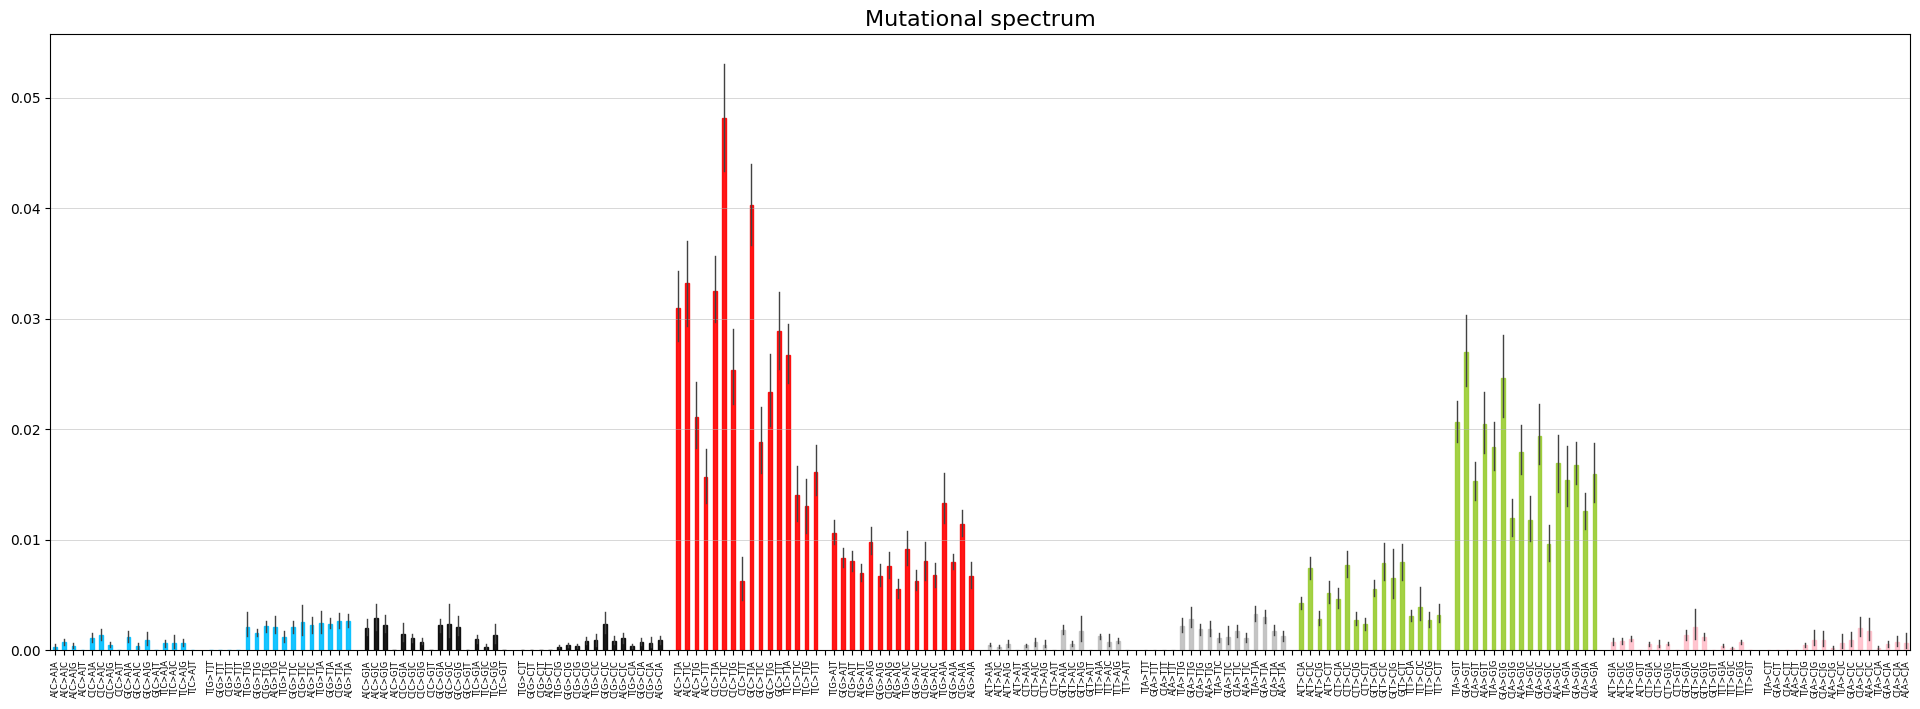

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [24]:
plot_mutspec192(spectra_old)

In [35]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [43]:
mut_new = final_mutspec.loc[final_mutspec['Species'].isin(spectra_old['Species'].unique())]
mut_old = spectra_old.loc[spectra_old['Species'].isin(mut_new['Species'].unique())]

In [44]:
sps_to_cosin = mut_new.Species.unique()

In [45]:
mut_new['Class'] = 'Vertebrata'
mut_new = calc_mutspec_class(mut_new)
mut_old['Class'] = 'Vertebrata'
mut_old = calc_mutspec_class(mut_old)

In [39]:
1 - spatial.distance.cosine(mut_new['MutSpec'], mut_old['MutSpec'])

0.9248450130741519

In [40]:
mutspec_bogdan = pd.read_csv('/home/kpotoh/nemu-pipeline/data/chordata2/raw_spectum192.csv')

mutspec_bogdan = mutspec_bogdan.drop('Unnamed: 0', axis=1)

mutspec_bogdan = mutspec_bogdan[mutspec_bogdan.Gene == 'Cytb']

mutspec_bogdan['ExpNum'] = np.where(mutspec_bogdan['ExpNum'] < 0.99, 0, mutspec_bogdan['ExpNum'])
mutspec_bogdan['ObsNum'] = np.where(mutspec_bogdan['ObsNum'] < 0.99, 0, mutspec_bogdan['ObsNum'])

### Norm again
mutspec_bogdan["RawMutSpec"] = (mutspec_bogdan["ObsNum"] / mutspec_bogdan["ExpNum"]).fillna(0)
mutspec_bogdan["RawMutSpec"] = mutspec_bogdan["RawMutSpec"].replace(np.inf, 0)
rawsum_df = mutspec_bogdan.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
mutspec_bogdan = pd.merge(mutspec_bogdan, rawsum_df, on="Species")
mutspec_bogdan["MutSpec"] = mutspec_bogdan["RawMutSpec"] / mutspec_bogdan["RawMutSpecSum"]


In [41]:
mutspec_bogdan['Mut'] = mutspec_bogdan.Mut.apply(getrevers) # change annotation to heavy STRAND
mutspec_bogdan["MutBase"] = mutspec_bogdan.Mut.str.slice(2, 5)
mutspec_bogdan["Context"] = mutspec_bogdan.Mut.str.get(0) + mutspec_bogdan.Mut.str.get(2) + mutspec_bogdan.Mut.str.get(-1)


In [46]:
mutspec_bogdan['Class'] = 'Vertebrata'

In [50]:
mut_bog = mutspec_bogdan.loc[mutspec_bogdan['Species'].isin(sps_to_cosin)]
mut_bog = calc_mutspec_class(mut_bog)

In [51]:
1 - spatial.distance.cosine(mut_new['MutSpec'], mut_bog['MutSpec'])

0.965254957470618

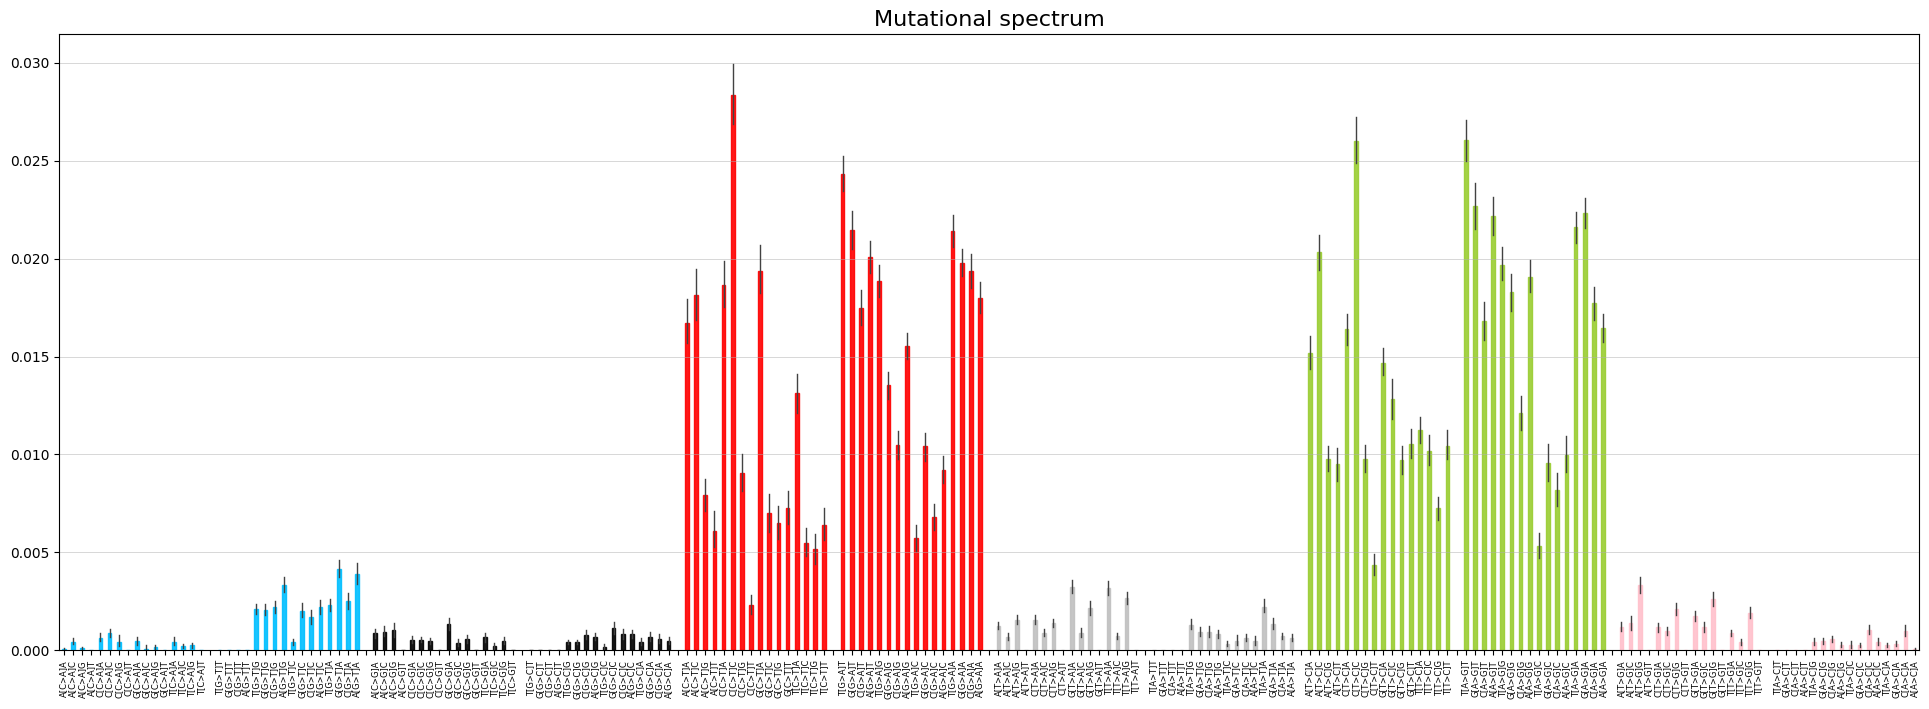

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [33]:
plot_mutspec192(mutspec_bogdan)